# PROJECT : Fake-Tweets with Bi-Grams & Stop_words

In [17]:
# importing the libaries

import pandas as pd
import numpy as np
import os

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from plotly import tools
import plotly.offline as py
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from nltk.corpus import stopwords
from nltk.util import ngrams

from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split , GridSearchCV , cross_val_score , KFold
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report , confusion_matrix , f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix , roc_curve , accuracy_score , precision_score , recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB , GaussianNB
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

from collections import defaultdict
from collections import Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))

import re
from nltk.tokenize import word_tokenize
import gensim
import string

from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from keras.optimizers import Adam

import folium 
from folium import plugins

from spellchecker import SpellChecker

In [18]:
# Load the train and test dataset

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('submission.csv')

In [19]:
train.shape

(7613, 5)

In [20]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [21]:
train.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [22]:
new_train = train
new_train['keyword'].fillna("No keyword",inplace=True)
new_train.isnull().sum()

id             0
keyword        0
location    2533
text           0
target         0
dtype: int64

In [23]:
# drop the location column both from train and test part

# train.drop(['location'] , axis = 1 , inplace = True)
# test.drop(['location'] , axis = 1 , inplace = True)

In [24]:
train.shape

(7613, 5)

## EDA

Text(0, 0.5, 'Number of samples')

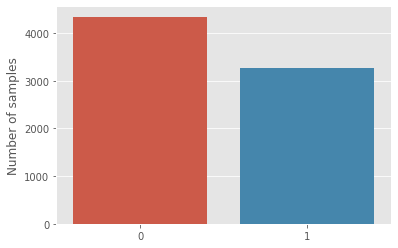

In [25]:
x=train.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('Number of samples')

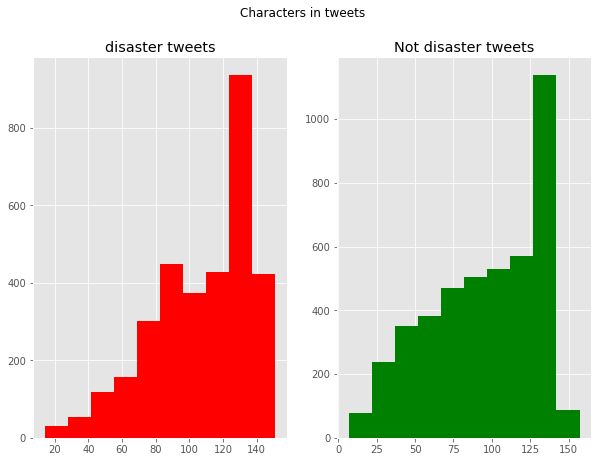

In [26]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,7))
tweet_len=train[train['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=train[train['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

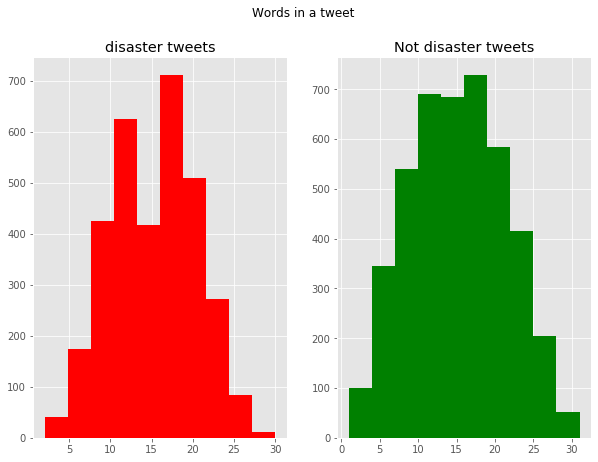

In [27]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,7))
tweet_len=train[train['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=train[train['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

Text(0.5, 0.98, 'Average word length in each tweet')

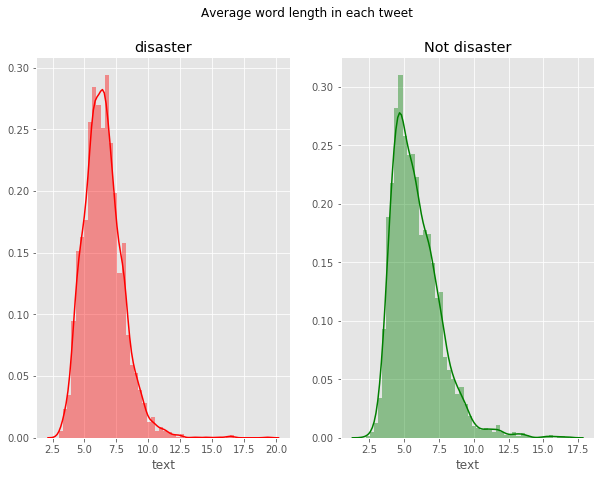

In [28]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,7))
word=train[train['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('disaster')
word=train[train['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')

In [30]:
# Tweets per location

cnt_ = train['location'].value_counts()
cnt_.reset_index()
cnt_ = cnt_[:20,]
trace1 = go.Bar(
                x = cnt_.index,
                y = cnt_.values,
                name = "Number of tweets in dataset according to location",
                marker = dict(color = 'rgba(200, 74, 55, 0.5)',
                             line=dict(color='rgb(0,0,0)',width=1.5)),
                )

data = [trace1]
layout = go.Layout(barmode = "group",title = 'Number of tweets depending on location')
fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

In [31]:
#Number of tweets depending on location per class

train1_df = train[train["target"]==1]
train0_df = train[train["target"]==0]
cnt_1 = train1_df['location'].value_counts()
cnt_1.reset_index()
cnt_1 = cnt_1[:20,]

cnt_0 = train0_df['location'].value_counts()
cnt_0.reset_index()
cnt_0 = cnt_0[:20,]

trace1 = go.Bar(
                x = cnt_1.index,
                y = cnt_1.values,
                name = "Number of real disaster tweets",
                marker = dict(color = 'rgba(255, 74, 55, 0.5)',
                             line=dict(color='rgb(0,0,0)',width=1.5)),
                )
trace0 = go.Bar(
                x = cnt_0.index,
                y = cnt_0.values,
                name = "Number of unreal disaster tweets",
                marker = dict(color = 'rgba(79, 82, 97, 0.5)',
                             line=dict(color='rgb(0,0,0)',width=1.5)),
                )


data = [trace0,trace1]
layout = go.Layout(barmode = 'stack',title = 'Number of tweets depending on location per class')
fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

#### Visualize per location using map

In [ ]:
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter


df = train['location'].value_counts()[:20,]
df = pd.DataFrame(df)
df = df.reset_index()
df.columns = ['location', 'counts'] 
geolocator = Nominatim(user_agent="specify_your_app_name_here")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
dictt_latitude = {}
dictt_longitude = {}
for i in df['location'].values:
    print(i)
    location = geocode(i)
    dictt_latitude[i] = location.latitude
    dictt_longitude[i] = location.longitude
df['latitude']= df['location'].map(dictt_latitude)
df['longitude'] = df['location'].map(dictt_longitude)

In [ ]:
map1 = folium.Map(location=[10.0, 10.0], tiles='CartoDB dark_matter', zoom_start=2.3)
markers = []
for i, row in df.iterrows():
    loss = row['counts']
    if row['counts'] > 0:
        count = row['counts']*0.4
    folium.CircleMarker([float(row['latitude']), float(row['longitude'])], radius=float(count), color='#ef4f61', fill=True).add_to(map1)
map1

It is clear that most of the tweets from america region.

#### Common Stopwords in tweets

In [17]:
def create_corpus(target):
    corpus =[]
    
    for x in train[train['target'] == target]['text'].str.split():
        for i in x:
            corpus.append(i)
            
    return corpus

In [18]:
corpus = create_corpus(1)

In [19]:
dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top = sorted(dic.items(), key = lambda x:x[1] , reverse = True)[:10] 

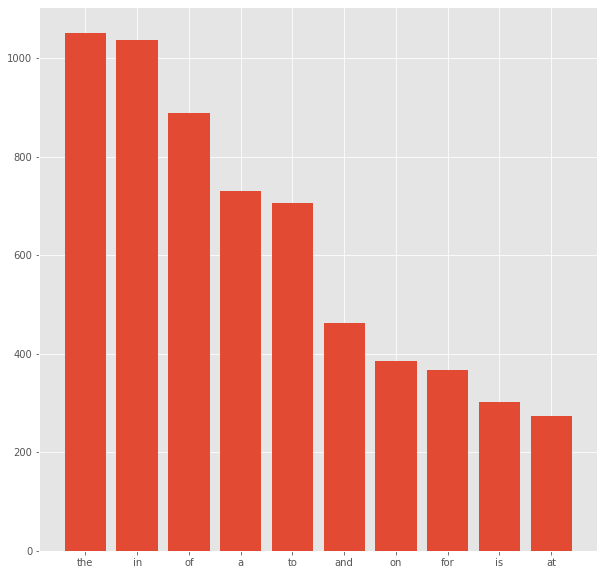

In [20]:
x , y = zip(*top)
plt.figure(figsize = (10 , 10))
plt.bar(x , y);

#### Analyzing Punctuations

<BarContainer object of 18 artists>

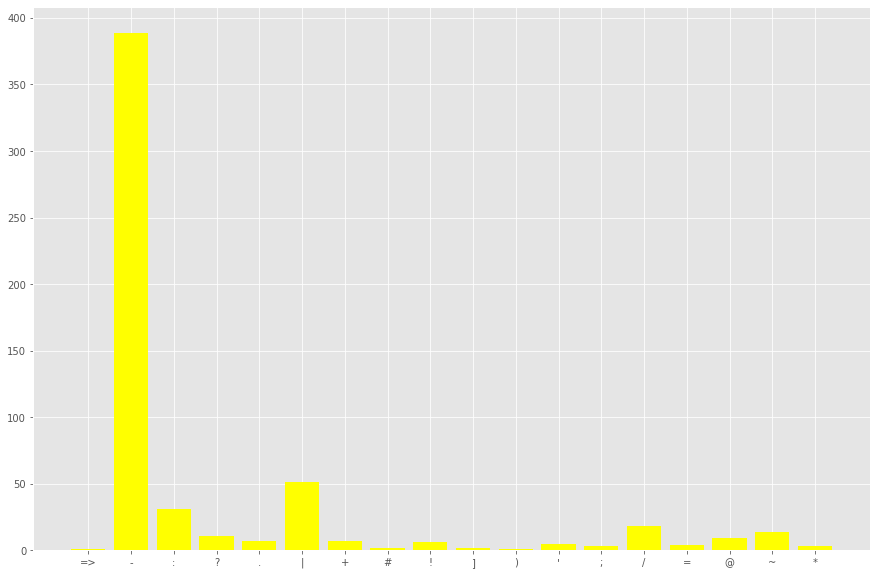

In [21]:
plt.figure(figsize=(15 , 10))

corpus = create_corpus(1)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y , color = 'yellow')

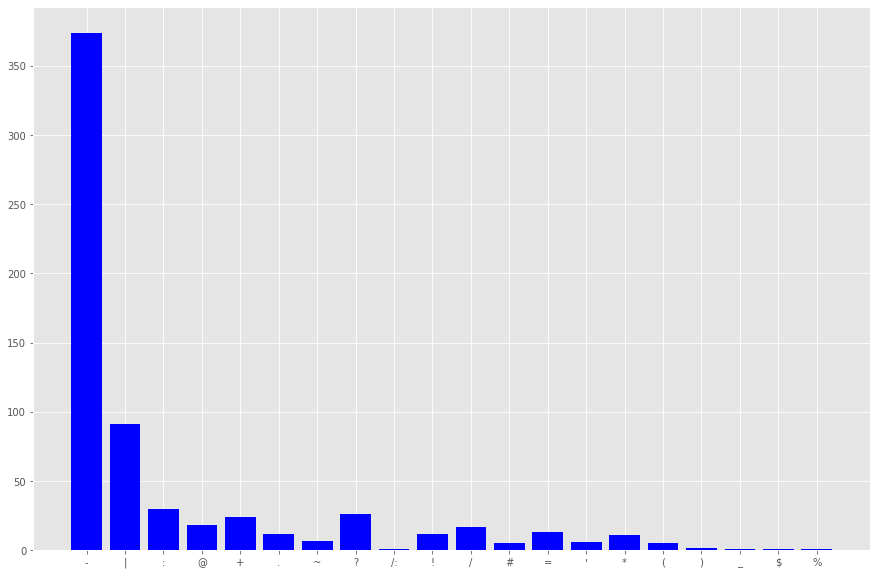

In [22]:
plt.figure(figsize=(15 , 10))
corpus = create_corpus(0)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x , y , color = 'blue');

#### Common Words

In [23]:
counter=Counter(corpus)
most=counter.most_common()

x=[]
y=[]

for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

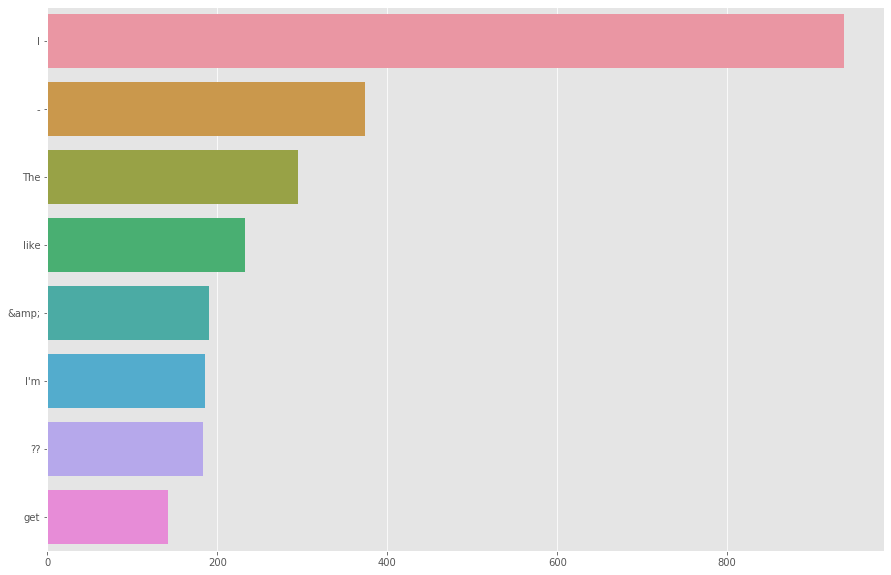

In [24]:
plt.figure(figsize=(15 , 10))
sns.barplot(x = y , y = x);

In [25]:
df = pd.concat([train , test])

## Data Preprocessing

1 . Removing stop words(Optional)

2 . Remove Punctuations

3 . Remove Html

4 . Remove Emojis

5 . Spelling Corrections

6 . Removing Urls

In [26]:
## Concate both train and test part
df_new = pd.concat([train , test])

In [27]:
df_new.shape

(10876, 5)

In [28]:
df_new.isnull().sum()

id             0
keyword       26
location    3638
text           0
target      3263
dtype: int64

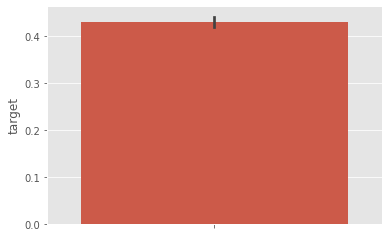

In [29]:
sns.barplot(y = 'target' , data = df_new)

In [30]:
df_new.head(20)

,id,keyword,location,text,target
0,1,No keyword,NaN,Our Deeds are the Reason of this #earthquake M...,1.0
1,4,No keyword,NaN,Forest fire near La Ronge Sask. Canada,1.0
2,5,No keyword,NaN,All residents asked to 'shelter in place' are ...,1.0
3,6,No keyword,NaN,"13,000 people receive #wildfires evacuation or...",1.0
4,7,No keyword,NaN,Just got sent this photo from Ruby #Alaska as ...,1.0
5,8,No keyword,NaN,#RockyFire Update => California Hwy. 20 closed...,1.0
6,10,No keyword,NaN,#flood #disaster Heavy rain causes flash flood...,1.0
7,13,No keyword,NaN,I'm on top of the hill and I can see a fire in...,1.0
8,14,No keyword,NaN,There's an emergency evacuation happening now ...,1.0
9,15,No keyword,NaN,I'm afraid that the tornado is coming to our a...,1.0


In [31]:
df_new.tail()

,id,keyword,location,text,target
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,NaN
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,NaN
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,NaN
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,NaN
3262,10875,NaN,NaN,#CityofCalgary has activated its Municipal Eme...,NaN


In [32]:
df_new['text'][0]

0    Our Deeds are the Reason of this #earthquake M...
0                   Just happened a terrible car crash
Name: text, dtype: object

In [33]:
df_new['text'][12]

12    #raining #flooding #Florida #TampaBay #Tampa 1...
12                               No don't tell me that!
Name: text, dtype: object

In [34]:
train['text'][0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

### Removing URLS

In [35]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

In [36]:
train['text'] = train['text'].apply(lambda x : remove_URL(x))
df_new['text'] = df_new['text'].apply(lambda x : remove_URL(x))
test['text'] = test['text'].apply(lambda x : remove_URL(x))

### Remove HTML tags

In [37]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

In [38]:
train['text'] = train['text'].apply(lambda x : remove_html(x))
df_new['text'] = df_new['text'].apply(lambda x : remove_URL(x))
test['text'] = test['text'].apply(lambda x : remove_html(x))

### Remove Emoji's

In [39]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [40]:
df_new['text']=df_new['text'].apply(lambda x: remove_emoji(x))
train['text'] = train['text'].apply(lambda x : remove_emoji(x))
test['text'] = test['text'].apply(lambda x : remove_emoji(x))

In [41]:
df_new['text'][12]

12    #raining #flooding #Florida #TampaBay #Tampa 1...
12                               No don't tell me that!
Name: text, dtype: object

### Remove Punctuations

In [42]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

In [43]:
df_new['text'] = df_new['text'].apply(lambda x : remove_punct(x))
train['text'] = train['text'].apply(lambda x : remove_punct(x))
test['text'] = test['text'].apply(lambda x : remove_punct(x))

In [44]:
df_new['text'][12]

12    raining flooding Florida TampaBay Tampa 18 or ...
12                                 No dont tell me that
Name: text, dtype: object

In [45]:
train['text'][12]

'raining flooding Florida TampaBay Tampa 18 or 19 days Ive lost count '

In [46]:
train.head()

,id,keyword,location,text,target
0,1,No keyword,NaN,Our Deeds are the Reason of this earthquake Ma...,1
1,4,No keyword,NaN,Forest fire near La Ronge Sask Canada,1
2,5,No keyword,NaN,All residents asked to shelter in place are be...,1
3,6,No keyword,NaN,13000 people receive wildfires evacuation orde...,1
4,7,No keyword,NaN,Just got sent this photo from Ruby Alaska as s...,1


In [47]:
train.tail()

,id,keyword,location,text,target
7608,10869,No keyword,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,No keyword,NaN,ariaahrary TheTawniest The out of control wild...,1
7610,10871,No keyword,NaN,M194 0104 UTC5km S of Volcano Hawaii,1
7611,10872,No keyword,NaN,Police investigating after an ebike collided w...,1
7612,10873,No keyword,NaN,The Latest More Homes Razed by Northern Califo...,1


### Spelling corrections

In [48]:
spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

In [49]:
# df_new['text'] = df_new['text'].apply(lambda x : correct_spellings(x))
# train['text'] = train['text'].apply(lambda x : correct_spellings(x))

In [50]:
train.tail()

,id,keyword,location,text,target
7608,10869,No keyword,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,No keyword,NaN,ariaahrary TheTawniest The out of control wild...,1
7610,10871,No keyword,NaN,M194 0104 UTC5km S of Volcano Hawaii,1
7611,10872,No keyword,NaN,Police investigating after an ebike collided w...,1
7612,10873,No keyword,NaN,The Latest More Homes Razed by Northern Califo...,1


In [51]:
df_new.head()

,id,keyword,location,text,target
0,1,No keyword,NaN,Our Deeds are the Reason of this earthquake Ma...,1.0
1,4,No keyword,NaN,Forest fire near La Ronge Sask Canada,1.0
2,5,No keyword,NaN,All residents asked to shelter in place are be...,1.0
3,6,No keyword,NaN,13000 people receive wildfires evacuation orde...,1.0
4,7,No keyword,NaN,Just got sent this photo from Ruby Alaska as s...,1.0


## Convert Text to Bi-grams

In [52]:
x = train.drop(['keyword' , 'location' , 'target'] , axis = 1)
y = train['target']

In [53]:
x

,id,text
0,1,Our Deeds are the Reason of this earthquake Ma...
1,4,Forest fire near La Ronge Sask Canada
2,5,All residents asked to shelter in place are be...
3,6,13000 people receive wildfires evacuation orde...
4,7,Just got sent this photo from Ruby Alaska as s...
...,...,...
7608,10869,Two giant cranes holding a bridge collapse int...
7609,10870,ariaahrary TheTawniest The out of control wild...
7610,10871,M194 0104 UTC5km S of Volcano Hawaii
7611,10872,Police investigating after an ebike collided w...


In [54]:
test

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [55]:
final_test = test.drop(['keyword' , 'location'] , axis = 1)
final_test

,id,text
0,0,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."
3,9,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...
3258,10861,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,Storm in RI worse than last hurricane. My city...
3260,10868,Green Line derailment in Chicago http://t.co/U...
3261,10874,MEG issues Hazardous Weather Outlook (HWO) htt...


In [56]:
final_test.shape

(3263, 2)

In [57]:
x_train , x_test , y_train , y_test = train_test_split(x , y , test_size = 0.20 , random_state = 78)

In [58]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)

(6090, 2)
(1523, 2)
(6090,)


### BOW on Text


In [59]:
count_vect = CountVectorizer(ngram_range = (1,2))
X_train_BOW = count_vect.fit_transform(x_train['text'])
X_test_BOW = count_vect.transform(x_test['text'])
test_BOW = count_vect.transform(test['text'])

In [60]:
print("**Bow Vectorizer**")
print("="*50)


print(X_train_BOW.shape)
print(X_test_BOW.shape)
print(test_BOW.shape)

**Bow Vectorizer**
(6090, 65995)
(1523, 65995)
(3263, 65995)


In [61]:
X_train_BOW

<6090x65995 sparse matrix of type '<class 'numpy.int64'>'
	with 153416 stored elements in Compressed Sparse Row format>

In [62]:
test_BOW

<3263x65995 sparse matrix of type '<class 'numpy.int64'>'
	with 57834 stored elements in Compressed Sparse Row format>

## Apply DIfferent ML model on Bi-grams

## Logistic Regression on Bi-grams

In [63]:
#Standardising the train and test data

sc = StandardScaler(copy = True , with_mean = False , with_std = True)
X_train = sc.fit_transform(X_train_BOW)
X_test = sc.transform(X_test_BOW)
Test = sc.transform(test_BOW)

In [64]:
tuned_parameters = [10**-4, 10**-2, 10**0, 10**2, 10**4]

cv_scores = []

for i in tqdm(tuned_parameters):
    model = LogisticRegression(penalty = 'l1' , C = i , n_jobs = -1)
    scores = cross_val_score(model , X_train , y_train , cv = 10 , scoring = 'accuracy' , n_jobs = -1)
    cv_scores.append(scores.mean())

100%|██████████| 5/5 [00:03<00:00,  1.26it/s]


In [65]:
optimal_C = tuned_parameters[cv_scores.index(max(cv_scores))]
print('\nThe optimal value of C is %.3f.' % optimal_C)


The optimal value of C is 0.000.


In [66]:
lr = LogisticRegression(penalty = 'l2' , C = 0.0001 , n_jobs = -1)
lr.fit(X_train , y_train)
pred = lr.predict(X_test)

ac = accuracy_score(y_test , pred)
print(ac*100)

77.60998030203545


***Test Data Report***
Best C =  0.0001
AUC =  73.41160762670775


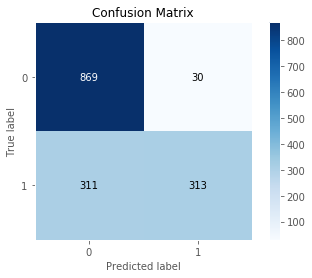

In [67]:
from sklearn import metrics
import scikitplot as skplt

print("***Test Data Report***")
print("Best C = ",optimal_C)
fpr, tpr, threshold = roc_curve(y_test , lr.predict(X_test))
auc = metrics.auc(fpr, tpr)
print("AUC = ",auc*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)
plt.show()

In [68]:
fpr, tpr, threshold = metrics.roc_curve(y_test , lr.predict(X_test))
fpr2, tpr2, threshold2 = metrics.roc_curve(y_test , lr.predict(X_test))

roc_auc = metrics.auc(fpr, tpr)
roc_auc2 = metrics.auc(fpr2, tpr2)

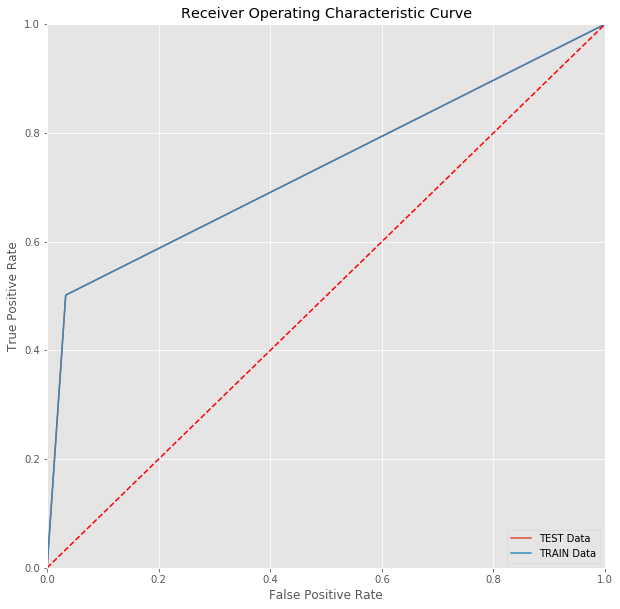

In [69]:
# plot ROC-curve
plt.figure(figsize = (10 , 10))
plt.title('Receiver Operating Characteristic Curve')
plt.gca()
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.plot(fpr2, tpr2, label = 'AUC = %0.2f' % roc_auc2)
plt.legend(['TEST Data', 'TRAIN Data'],loc = 'lower right')

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [70]:
feature_name = count_vect.get_feature_names()
w = lr.coef_
weight=w.reshape(-1)
sorted_feature = np.argsort(weight)
top_20_positive_feature=sorted_feature[:-20:-1]

In [71]:
print("Positive feature top 20 :")
print("-------")
for i in top_20_positive_feature:
    print("%s\t-->\t%f"%(feature_name[i],weight[i]))

Positive feature top 20 :
-------
in	-->	0.016588
california	-->	0.013191
hiroshima	-->	0.012945
suicide	-->	0.011803
wildfire	-->	0.011576
mh370	-->	0.010918
killed	-->	0.010884
bombing	-->	0.010662
fires	-->	0.010602
fire	-->	0.010084
northern	-->	0.009780
homes	-->	0.009541
atomic	-->	0.008919
after	-->	0.008803
bomber	-->	0.008749
suicide bomber	-->	0.008749
confirmed	-->	0.008683
debris	-->	0.008647
northern california	-->	0.008628


In [72]:
w = lr.coef_
weight=w.reshape(-1)
sorted_feature = np.argsort(weight)
feature_name = count_vect.get_feature_names()
top_20_negative_feature = sorted_feature[:20]

In [73]:
print("Negative feature top 20 :")
print("-------")
for i in top_20_negative_feature:
    print("%s\t -->\t%f  "%(feature_name[i],weight[i]))

Negative feature top 20 :
-------
you	 -->	-0.013541  
my	 -->	-0.011855  
im	 -->	-0.009111  
just	 -->	-0.007626  
body	 -->	-0.007546  
me	 -->	-0.007426  
love	 -->	-0.006967  
panic	 -->	-0.006123  
your	 -->	-0.006091  
bags	 -->	-0.006056  
nowplaying	 -->	-0.005835  
wrecked	 -->	-0.005820  
ruin	 -->	-0.005819  
full	 -->	-0.005818  
like	 -->	-0.005686  
youtube	 -->	-0.005663  
lol	 -->	-0.005485  
blazing	 -->	-0.005449  
harm	 -->	-0.005427  
do you	 -->	-0.005401  


In the above list it is clear that there are so many stop words that affects our model.we have to remove the stopwords.

## Apply KNN on Bi-grams

In [74]:
knn = KNeighborsClassifier()
knn.fit(X_train , y_train)

y_pred_knn = knn.predict(X_test)

ac = accuracy_score(y_test , y_pred_knn)
print(ac*100)

69.92777413000657


In [75]:
n_folds = 5
parameters = {
        'n_neighbors': range (2 , 50 , 2)
        }


In [76]:
knn = KNeighborsClassifier()

tree = GridSearchCV(estimator = knn , param_grid = parameters , cv = n_folds , n_jobs = -1 , return_train_score = True)
tree.fit(X_train , y_train)

score1 = tree.cv_results_

print(pd.DataFrame(score1).head())
print(tree.best_params_)

   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.008578      0.000490         0.570312        0.020096   
1       0.011473      0.004513         0.559287        0.022238   
2       0.008647      0.002680         0.506619        0.037784   
3       0.013257      0.009956         0.744032        0.223878   
4       0.012118      0.006484         0.815018        0.234942   

  param_n_neighbors               params  split0_test_score  \
0                 2   {'n_neighbors': 2}           0.678982   
1                 4   {'n_neighbors': 4}           0.638752   
2                 6   {'n_neighbors': 6}           0.620690   
3                 8   {'n_neighbors': 8}           0.609195   
4                10  {'n_neighbors': 10}           0.605090   

   split1_test_score  split2_test_score  split3_test_score  ...  \
0           0.676519           0.662562           0.484401  ...   
1           0.675698           0.644499           0.674877  ...   
2           0.641

In [77]:
score1 = pd.DataFrame(score1)
score1.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.008578,0.000490,0.570312,0.020096,2,{'n_neighbors': 2},0.678982,0.676519,0.662562,0.484401,...,0.626108,0.073145,3,0.971470,0.976190,0.975780,0.978038,0.684934,0.917282,0.116194
1,0.011473,0.004513,0.559287,0.022238,4,{'n_neighbors': 4},0.638752,0.675698,0.644499,0.674877,...,0.650903,0.021406,1,0.678161,0.976190,0.831897,0.979885,0.660509,0.825328,0.138213
2,0.008647,0.002680,0.506619,0.037784,6,{'n_neighbors': 6},0.620690,0.641215,0.624795,0.652709,...,0.631034,0.013803,2,0.633621,0.673645,0.678161,0.788793,0.638342,0.682512,0.056097
3,0.013257,0.009956,0.744032,0.223878,8,{'n_neighbors': 8},0.609195,0.629721,0.609195,0.642036,...,0.619704,0.013772,4,0.617200,0.646757,0.638342,0.665025,0.621100,0.637685,0.017463
4,0.012118,0.006484,0.815018,0.234942,10,{'n_neighbors': 10},0.605090,0.619869,0.605911,0.625616,...,0.612315,0.008711,5,0.607759,0.628079,0.628284,0.636289,0.614327,0.622947,0.010371


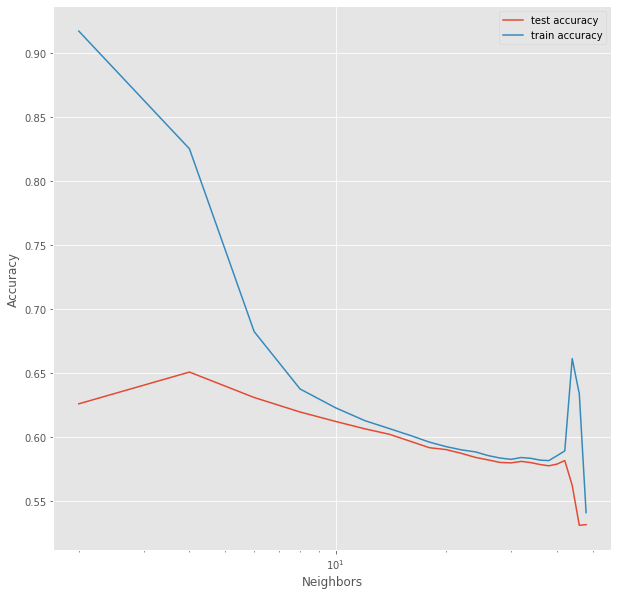

In [78]:
plt.figure(figsize=(10 , 10))
plt.plot(score1['param_n_neighbors'], score1['mean_test_score'])
plt.plot(score1['param_n_neighbors'], score1['mean_train_score'])
plt.xlabel('Neighbors')
plt.ylabel('Accuracy')
plt.legend(['test accuracy', 'train accuracy'] , loc='upper right')
plt.xscale('log')

In [79]:
knn = KNeighborsClassifier(n_neighbors = 12 , algorithm = 'kd_tree')
knn.fit(X_train , y_train)

y_pred_knn = knn.predict(X_test)

ac_knn = accuracy_score(y_test , y_pred_knn)
print('After Cross-validation: ',ac*100)

C:\Users\Mahmudur Limon\Anaconda3\envs\gputest\lib\site-packages\sklearn\neighbors\_base.py:413: UserWarning:

cannot use tree with sparse input: using brute force



After Cross-validation:  69.92777413000657


## Naive-Bayes on Bi-grams

In [80]:
alpha = [] 
i = 0.001

while(i <= 1000):
    alpha.append(np.round(i,3))
    i *= 3

cv_scores = []

for k in tqdm(alpha):
    model = MultinomialNB(alpha = k)
    scores = cross_val_score(model , X_train , y_train , cv = 10 , scoring = 'f1_macro' , n_jobs = -1)
    cv_scores.append(scores.mean()) 

100%|██████████| 13/13 [00:01<00:00,  8.31it/s]


In [81]:
optimal_alpha = alpha[cv_scores.index(max(cv_scores))]
print('\nThe optimal value of alpha is %.3f.' % optimal_alpha)


The optimal value of alpha is 0.003.


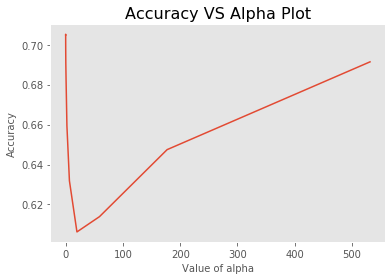


*******Train Data Report******

Alpha values :
 [0.001, 0.003, 0.009, 0.027, 0.081, 0.243, 0.729, 2.187, 6.561, 19.683, 59.049, 177.147, 531.441]

F1 Score for each value of alpha :
  [70.486 70.523 70.464 70.166 69.774 69.091 68.203 65.932 63.184 60.624
 61.389 64.745 69.141]


In [82]:
# plot accuracy vs alpha 
plt.plot(alpha, cv_scores)
plt.xlabel('Value of alpha',size=10)
plt.ylabel('Accuracy',size=10)
plt.title('Accuracy VS Alpha Plot',size=16)
plt.grid()
plt.show()
print("\n*******Train Data Report******");
print("\nAlpha values :\n",alpha)
print("\nF1 Score for each value of alpha :\n ", np.round(cv_scores,5)*100)

In [83]:
model_bow_multinomial = MultinomialNB(alpha = optimal_alpha)

model_bow_multinomial.fit(X_train , y_train)

pred = model_bow_multinomial.predict(X_test)

***Test Data Report***
Accuracy =  76.16546290216678
f1_score =  75.36820775485162
precision_score =  75.36204899777283
recall_score =  75.37443669604404


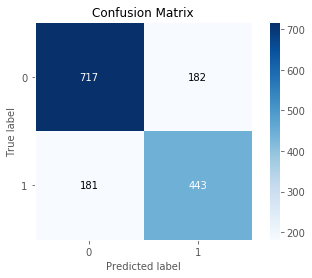

In [84]:
print("***Test Data Report***")
print('Accuracy = ', accuracy_score(y_test, pred)*100)
print("f1_score = ",f1_score(y_test, pred, average='macro')*100)

print("precision_score = " , precision_score(y_test , pred, average='macro')*100)
print("recall_score = " , recall_score(y_test, pred, average='macro')*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)

plt.show()

In [85]:
print(classification_report(y_test , pred))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80       899
           1       0.71      0.71      0.71       624

    accuracy                           0.76      1523
   macro avg       0.75      0.75      0.75      1523
weighted avg       0.76      0.76      0.76      1523



## SVM on Bi-grams

In [86]:
sv = SVC()
sv.fit(X_train , y_train)

y_pred_svm = sv.predict(X_test)

ac_svr = accuracy_score(y_test , y_pred_svm)
print(ac_svr*100)

73.60472751149048


In [87]:
folds = KFold(n_splits = 5, shuffle = True, random_state = 4)
params = {"C": [0.01 , 0.1, 1, 10, 100, 1000]}

model = SVC()

model_cv_C = GridSearchCV(estimator = model, param_grid = params, cv = folds , verbose = 1 , return_train_score=True , n_jobs = -1)
model_cv_C.fit(X_train, y_train) 


cv_results = pd.DataFrame(model_cv_C.cv_results_)
cv_results

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.6min finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,9.988698,0.581756,2.136782,0.057476,0.01,{'C': 0.01},0.581281,0.536946,0.574713,0.591133,...,0.565353,0.021570,5,0.561371,0.572455,0.563013,0.558908,0.571018,0.565353,0.005393
1,9.464100,0.095201,2.222228,0.099492,0.1,{'C': 0.1},0.581281,0.536946,0.574713,0.591133,...,0.565353,0.021570,5,0.561371,0.572455,0.563013,0.558908,0.571018,0.565353,0.005393
2,9.227693,0.156621,2.319916,0.142315,1,{'C': 1},0.686371,0.646962,0.692118,0.694581,...,0.675205,0.019763,4,0.983990,0.983785,0.983169,0.981732,0.980706,0.982677,0.001263
3,9.102199,0.177339,2.026402,0.064170,10,{'C': 10},0.698686,0.668309,0.717570,0.728243,...,0.698030,0.022832,3,0.990764,0.991174,0.990558,0.989122,0.989737,0.990271,0.000741
4,8.942864,0.086387,2.013414,0.062261,100,{'C': 100},0.700328,0.667488,0.719212,0.732348,...,0.699179,0.024579,1,0.990969,0.991174,0.990764,0.989122,0.989943,0.990394,0.000761
5,8.340878,0.788270,1.815210,0.240662,1000,{'C': 1000},0.698686,0.667488,0.719212,0.726601,...,0.698358,0.022494,2,0.991174,0.991174,0.991174,0.989327,0.990148,0.990599,0.000750


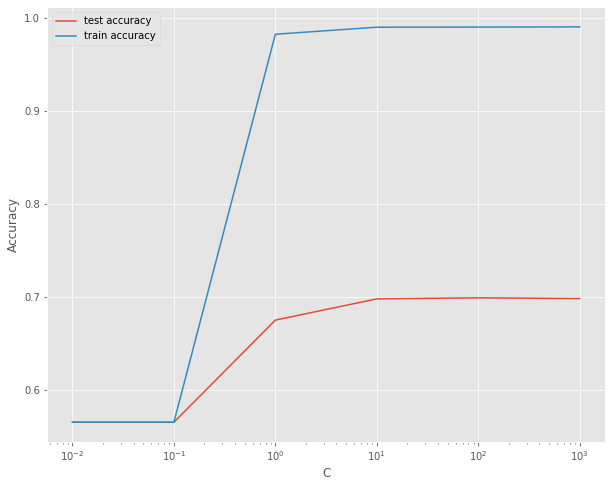

In [88]:
plt.figure(figsize=(10 , 8))
plt.plot(cv_results['param_C'], cv_results['mean_test_score'])
plt.plot(cv_results['param_C'], cv_results['mean_train_score'])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

In [89]:
folds = KFold(n_splits = 5, shuffle = True, random_state = 4)
gamma = {'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}

model = SVC()

model_cv_g = GridSearchCV(estimator = model, param_grid = gamma, cv = folds , verbose = 1 , return_train_score=True ,  n_jobs = -1)
model_cv_g.fit(X_train, y_train) 

cv_results_g = pd.DataFrame(model_cv_g.cv_results_)
cv_results_g

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  2.4min finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,11.315542,0.159606,2.596127,0.026218,1,{'gamma': 1},0.628079,0.605911,0.629721,0.642036,...,0.622167,0.014441,3,0.991174,0.991174,0.991174,0.989327,0.990148,0.990599,0.000750
1,11.048446,0.097292,2.588840,0.018039,0.1,{'gamma': 0.1},0.628079,0.605911,0.629721,0.642036,...,0.622167,0.014441,3,0.991174,0.991174,0.991174,0.989327,0.990148,0.990599,0.000750
2,10.960976,0.021739,2.582730,0.022869,0.01,{'gamma': 0.01},0.628079,0.605911,0.629721,0.642036,...,0.622167,0.014441,3,0.991174,0.991174,0.991174,0.989327,0.990148,0.990599,0.000750
3,8.966427,0.130520,2.225685,0.148807,0.001,{'gamma': 0.001},0.629721,0.605911,0.633005,0.642036,...,0.623153,0.014969,2,0.990969,0.991174,0.990764,0.989122,0.989943,0.990394,0.000761
4,8.676113,0.539717,1.899062,0.319597,0.0001,{'gamma': 0.0001},0.645320,0.618227,0.656814,0.660920,...,0.639901,0.018422,1,0.990558,0.991174,0.990353,0.988506,0.989737,0.990066,0.000905


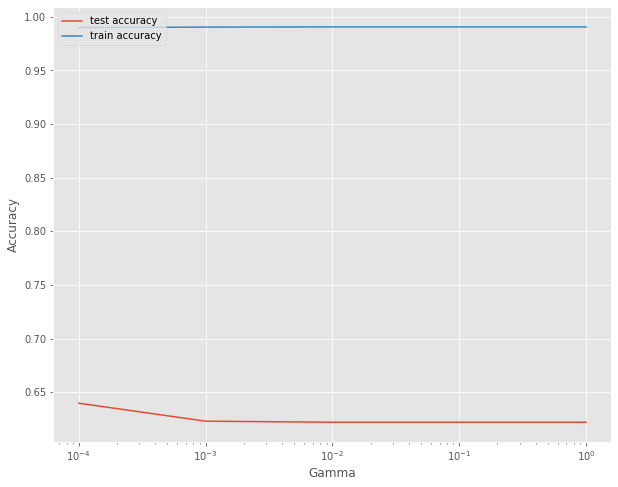

In [90]:
plt.figure(figsize=(10 , 8))
plt.plot(cv_results_g['param_gamma'], cv_results_g['mean_test_score'])
plt.plot(cv_results_g['param_gamma'], cv_results_g['mean_train_score'])
plt.xlabel('Gamma')
plt.ylabel('Accuracy')
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

In [91]:
print(model_cv_C.best_params_)
print(model_cv_g.best_params_)

{'C': 100}
{'gamma': 0.0001}


In [92]:
sv = SVC(C = 10 , gamma = 0.0001)
sv.fit(X_train , y_train)

y_pred_svm = sv.predict(X_test)

ac_svr = accuracy_score(y_test , y_pred_svm)
print(ac_svr*100)

68.68023637557452


In [93]:
from sklearn import linear_model
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score

alpha = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]
auc_score=[]


for i in tqdm(alpha):
    model = linear_model.SGDClassifier(alpha=i, loss='hinge', class_weight='balanced')
    model.fit(X_train, y_train)
    
    Cal_CV_model = CalibratedClassifierCV(model, method="sigmoid",cv=10)
    Cal_CV_model.fit(X_train, y_train)
    predict_y = Cal_CV_model.predict_proba(X_train)
    preds = predict_y[:,1]
    roc_auc = roc_auc_score(y_train, preds)
    auc_score.append(roc_auc)

100%|██████████| 9/9 [00:03<00:00,  2.33it/s]


In [94]:
# determining best value of alpha
optimal_alpha = alpha[auc_score.index(max(auc_score))]
print('\nThe optimal value of alpha is %.3f.' % optimal_alpha)


The optimal value of alpha is 0.100.


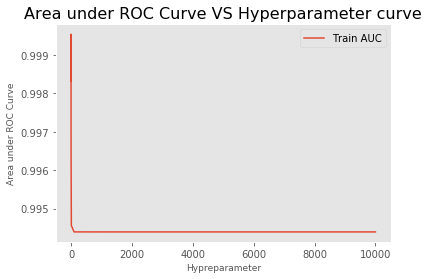

In [95]:
# plot accuracy vs alpha 
plt.plot(alpha, auc_score,label="Train AUC")
plt.xlabel('Hypreparameter',size=9)
plt.ylabel('Area under ROC Curve',size=9)
plt.title('Area under ROC Curve VS Hyperparameter curve',size=16)
plt.legend(loc='best')
plt.grid()
plt.show()

***Test Data Report***
Best alpha =  0.1
AUC =  77.06648769287813


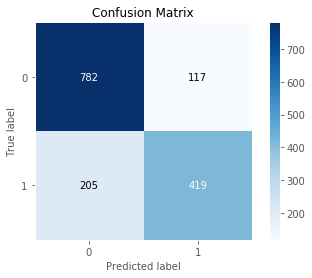

In [96]:
model = linear_model.SGDClassifier(alpha=optimal_alpha, loss='hinge', class_weight='balanced')
model.fit(X_train, y_train)

lr = CalibratedClassifierCV(model, method="sigmoid",cv=10)
lr.fit(X_train, y_train)
pred = lr.predict(X_test)


print("***Test Data Report***")
print("Best alpha = ",optimal_alpha)
fpr, tpr, threshold = metrics.roc_curve(y_test, lr.predict(X_test))
auc = metrics.auc(fpr, tpr)
print("AUC = ",auc*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)
plt.show()

## Decision Tree on Bi-grams

In [97]:
dt = DecisionTreeClassifier()
dt.fit(X_train , y_train)


y_pred_dt = dt.predict(X_test)

ac = accuracy_score(y_test , y_pred_dt)
print(ac*100)

73.86736703873933


In [98]:
n_folds = 5
parameters = {'min_samples_split': range(20 , 200 , 20)}

dtree = DecisionTreeClassifier(random_state = 100)

tree_split = GridSearchCV(dtree, parameters , cv=n_folds , n_jobs = -1 , return_train_score = True)
tree_split.fit(X_train, y_train)


cv_results_ms = pd.DataFrame(tree_split.cv_results_)
cv_results_ms

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,6.644529,0.455717,0.006248,0.007653,20,{'min_samples_split': 20},0.735632,0.756979,0.742200,0.739737,...,0.738259,0.012944,2,0.952176,0.948892,0.939860,0.939860,0.948276,0.945813,0.005038
1,6.135681,0.542151,0.000000,0.000000,40,{'min_samples_split': 40},0.737274,0.747126,0.744663,0.732348,...,0.735796,0.010519,5,0.926929,0.930624,0.918719,0.922414,0.930624,0.925862,0.004678
2,5.743402,0.457389,0.000000,0.000000,60,{'min_samples_split': 60},0.735632,0.741379,0.741379,0.736453,...,0.736946,0.004269,4,0.915025,0.931240,0.912767,0.911125,0.919130,0.917857,0.007211
3,5.595994,0.461071,0.000000,0.000000,80,{'min_samples_split': 80},0.738095,0.743842,0.740558,0.738095,...,0.738095,0.004615,3,0.908046,0.913793,0.901478,0.900246,0.903325,0.905378,0.004974
4,5.576580,0.476361,0.000000,0.000000,100,{'min_samples_split': 100},0.737274,0.742200,0.738916,0.736453,...,0.738588,0.001984,1,0.905378,0.900862,0.894499,0.890599,0.895320,0.897332,0.005188
5,5.626242,0.470163,0.000000,0.000000,120,{'min_samples_split': 120},0.731527,0.743021,0.741379,0.730706,...,0.734975,0.006020,6,0.899631,0.888752,0.895115,0.886494,0.891831,0.892365,0.004651
6,5.552720,0.498975,0.000000,0.000000,140,{'min_samples_split': 140},0.730706,0.734811,0.740558,0.730706,...,0.733662,0.003766,7,0.897167,0.878284,0.893268,0.884031,0.888547,0.888259,0.006662
7,5.752476,0.468371,0.001995,0.001093,160,{'min_samples_split': 160},0.730706,0.734811,0.740558,0.730706,...,0.733662,0.003766,7,0.897167,0.875616,0.893268,0.884031,0.886084,0.887233,0.007505
8,5.078639,1.237870,0.001994,0.000632,180,{'min_samples_split': 180},0.730706,0.733169,0.740558,0.730706,...,0.733333,0.003723,9,0.897167,0.872947,0.893268,0.884031,0.882389,0.885961,0.008542


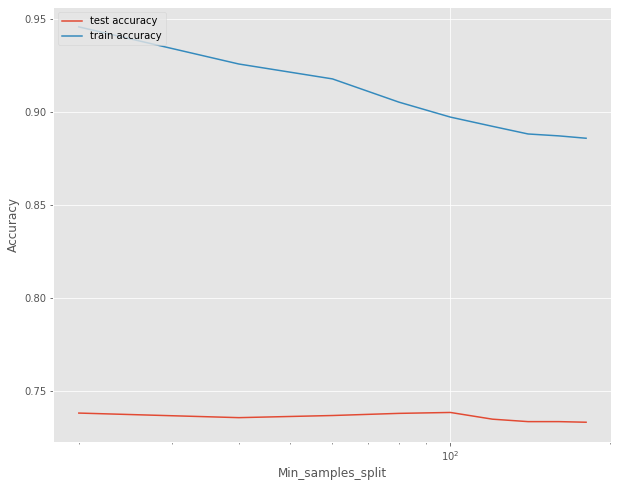

In [99]:
plt.figure(figsize=(10 , 8))
plt.plot(cv_results_ms['param_min_samples_split'] , cv_results_ms['mean_test_score'])
plt.plot(cv_results_ms['param_min_samples_split'] , cv_results_ms['mean_train_score'])
plt.xlabel('Min_samples_split')
plt.ylabel('Accuracy')
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

In [100]:
n_folds = 5
parameters = {'min_samples_leaf': range (1 , 20)}

dtree = DecisionTreeClassifier()

tree_ml = GridSearchCV(dtree , parameters , cv=n_folds , n_jobs = -1 , return_train_score = True)
tree_ml.fit(X_train, y_train)


cv_results_ml = pd.DataFrame(tree_ml.cv_results_)
cv_results_ml

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,7.284526,0.588517,0.002195,0.000399,1,{'min_samples_leaf': 1},0.724959,0.743842,0.730706,0.734811,...,0.730378,0.008882,1,0.990969,0.991995,0.989532,0.990558,0.989943,0.990599,0.000855
1,6.099945,0.352554,0.001198,0.000978,2,{'min_samples_leaf': 2},0.724959,0.738095,0.731527,0.715107,...,0.727422,0.007596,3,0.911946,0.904967,0.905172,0.909688,0.907020,0.907759,0.002694
2,4.930886,0.174957,0.000000,0.000000,3,{'min_samples_leaf': 3},0.701970,0.711823,0.710181,0.726601,...,0.712644,0.007943,12,0.870690,0.862274,0.871305,0.868842,0.864532,0.867529,0.003538
3,4.280249,0.127292,0.006249,0.007653,4,{'min_samples_leaf': 4},0.724959,0.711002,0.727422,0.744663,...,0.727258,0.010710,4,0.843186,0.832512,0.840107,0.834770,0.835181,0.837151,0.003904
4,3.768898,0.252560,0.006250,0.007654,5,{'min_samples_leaf': 5},0.723317,0.728243,0.739737,0.721675,...,0.728243,0.006317,2,0.822455,0.818760,0.819787,0.815271,0.812192,0.817693,0.003587
5,3.390508,0.161870,0.000399,0.000799,6,{'min_samples_leaf': 6},0.733990,0.735632,0.714286,0.732348,...,0.725123,0.011020,5,0.809729,0.803777,0.810140,0.804187,0.799672,0.805501,0.003952
6,3.072889,0.122186,0.006249,0.007653,7,{'min_samples_leaf': 7},0.722496,0.731527,0.715928,0.715107,...,0.718555,0.008001,8,0.796593,0.794951,0.801314,0.788383,0.791667,0.794581,0.004391
7,2.853213,0.122512,0.000000,0.000000,8,{'min_samples_leaf': 8},0.730706,0.728243,0.711823,0.711823,...,0.716092,0.012082,9,0.790640,0.779762,0.794745,0.784688,0.779351,0.785837,0.006045
8,2.670771,0.107378,0.002196,0.000977,9,{'min_samples_leaf': 9},0.728243,0.723317,0.704433,0.715928,...,0.714943,0.010061,10,0.780788,0.772167,0.788383,0.777915,0.771141,0.778079,0.006271
9,2.452443,0.096161,0.002195,0.001465,10,{'min_samples_leaf': 10},0.722496,0.722496,0.706897,0.708539,...,0.713629,0.007258,11,0.774836,0.767241,0.783456,0.768473,0.766010,0.772003,0.006485


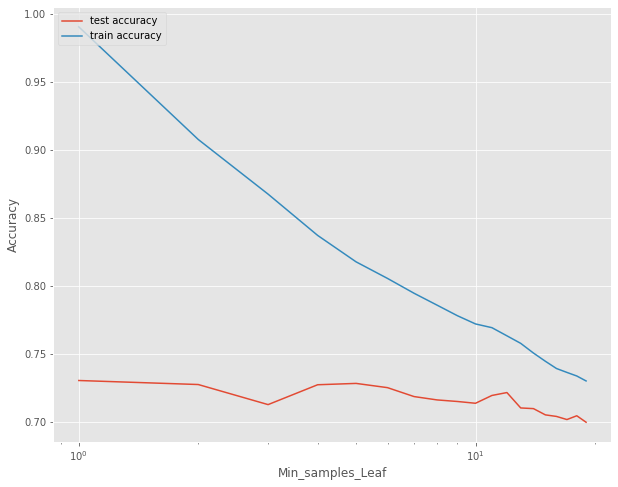

In [101]:
plt.figure(figsize=(10 , 8))
plt.plot(cv_results_ml['param_min_samples_leaf'] , cv_results_ml['mean_test_score'])
plt.plot(cv_results_ml['param_min_samples_leaf'] , cv_results_ml['mean_train_score'])
plt.xlabel('Min_samples_Leaf')
plt.ylabel('Accuracy')
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

In [102]:
n_folds = 5
parameters = {'max_depth':range (1,20)}

dtree = DecisionTreeClassifier()

tree_d = GridSearchCV(dtree , parameters , cv=n_folds , n_jobs = -1 , return_train_score = True)
tree_d.fit(X_train, y_train)


cv_results_d = pd.DataFrame(tree_d.cv_results_)
cv_results_d

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.617712,0.014233,0.000399,0.000798,1,{'max_depth': 1},0.614943,0.565681,0.598522,0.595238,...,0.591790,0.016292,19,0.598933,0.565271,0.603038,0.603859,0.606527,0.595525,0.015322
1,0.679638,0.037407,0.000399,0.000798,2,{'max_depth': 2},0.630542,0.624795,0.607553,0.605911,...,0.615271,0.010302,18,0.617816,0.608580,0.623974,0.612479,0.625205,0.617611,0.006420
2,0.683186,0.006112,0.008249,0.007040,3,{'max_depth': 3},0.644499,0.640394,0.616585,0.609195,...,0.626601,0.013654,17,0.634852,0.626026,0.635263,0.621100,0.642241,0.631897,0.007458
3,0.741429,0.011671,0.000000,0.000000,4,{'max_depth': 4},0.642857,0.648604,0.636289,0.623153,...,0.636125,0.009060,16,0.637521,0.637931,0.650452,0.634031,0.654351,0.642857,0.008005
4,0.791648,0.022384,0.003124,0.006248,5,{'max_depth': 5},0.643678,0.654351,0.636289,0.636289,...,0.639737,0.008818,15,0.651683,0.651683,0.653120,0.644704,0.659893,0.652217,0.004832
5,0.831055,0.018217,0.000000,0.000000,6,{'max_depth': 6},0.650246,0.658456,0.646962,0.647783,...,0.646305,0.009980,14,0.662356,0.664614,0.667693,0.656404,0.662151,0.662644,0.003705
6,0.877920,0.020724,0.006250,0.007654,7,{'max_depth': 7},0.650246,0.660920,0.643678,0.651067,...,0.650739,0.005702,13,0.666872,0.669335,0.672209,0.670772,0.678161,0.671470,0.003782
7,0.934155,0.011690,0.003124,0.006249,8,{'max_depth': 8},0.643678,0.664204,0.646141,0.666667,...,0.653859,0.009611,12,0.675082,0.682061,0.685755,0.684729,0.688834,0.683292,0.004643
8,0.993518,0.028973,0.006249,0.007653,9,{'max_depth': 9},0.650246,0.665846,0.650246,0.666667,...,0.658949,0.007299,11,0.682266,0.694171,0.694787,0.698276,0.701765,0.694253,0.006582
9,1.046630,0.019759,0.003124,0.006248,10,{'max_depth': 10},0.650246,0.671593,0.649425,0.670772,...,0.659278,0.009866,10,0.690271,0.702997,0.704023,0.709360,0.713875,0.704105,0.007946


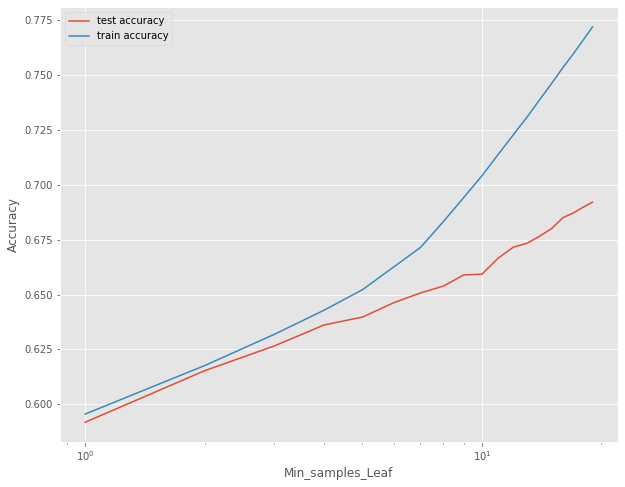

In [103]:
plt.figure(figsize=(10 , 8))
plt.plot(cv_results_d['param_max_depth'] , cv_results_d['mean_test_score'])
plt.plot(cv_results_d['param_max_depth'] , cv_results_d['mean_train_score'])
plt.xlabel('Min_samples_Leaf')
plt.ylabel('Accuracy')
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

In [104]:
print(tree_split.best_params_)
print(tree_ml.best_params_)
print(tree_d.best_params_)

{'min_samples_split': 100}
{'min_samples_leaf': 1}
{'max_depth': 19}


In [105]:
dt = DecisionTreeClassifier(max_depth = 20 , min_samples_leaf = 10 , min_samples_split = 80)
dt.fit(X_train , y_train)


y_pred_dt = dt.predict(X_test)

ac = accuracy_score(y_test , y_pred_dt)
print(ac*100)

71.89757058437294


***Test Data Report***
Best max_depth =  20
Best min_samples_split =  80
AUC =  77.06648769287813


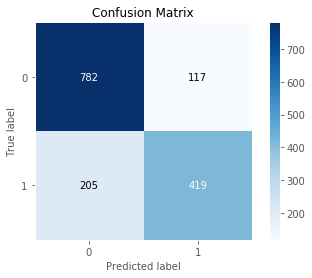

In [106]:
optimal_depth = 20
optimal_split = 80

print("***Test Data Report***")
print("Best max_depth = ",optimal_depth)
print("Best min_samples_split = ",optimal_split)
fpr, tpr, threshold = metrics.roc_curve(y_test, lr.predict(X_test))
auc = metrics.auc(fpr, tpr)
print("AUC = ",auc*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)
plt.show()

## Random Forest on Bi-grams

In [107]:
max_depths = [2,4,6,9,11]
base_learners = [1, 5, 10, 50, 100]
param_grid = {'max_depth': max_depths,'n_estimators':base_learners}


model = GridSearchCV(RandomForestClassifier(class_weight='balanced'), param_grid, scoring = 'roc_auc', cv=3 , n_jobs = -1 , return_train_score = True)
model.fit(X_train, y_train)

print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_train, y_train))

Model with best parameters :
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Accuracy of the model :  0.8664166526126115


In [108]:
y_pred_rf = model.predict(X_test)
ac = accuracy_score(y_test , y_pred_rf)
ac

0.7504924491135916

In [109]:
dataframe = pd.DataFrame(model.cv_results_)
dataframe.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.012144,0.000000,0.005210,0.007368,2,1,"{'max_depth': 2, 'n_estimators': 1}",0.506236,0.508066,0.519256,0.511186,0.005755,25,0.507281,0.510388,0.519304,0.512324,0.005096
1,0.054461,0.011351,0.006274,0.008872,2,5,"{'max_depth': 2, 'n_estimators': 5}",0.599415,0.593810,0.527647,0.573624,0.032591,19,0.581418,0.605497,0.535388,0.574101,0.029086
2,0.110514,0.009370,0.009530,0.006826,2,10,"{'max_depth': 2, 'n_estimators': 10}",0.543431,0.557834,0.575084,0.558783,0.012940,20,0.557569,0.577954,0.589548,0.575023,0.013219
3,0.321136,0.016879,0.051097,0.005986,2,50,"{'max_depth': 2, 'n_estimators': 50}",0.705873,0.704038,0.699120,0.703010,0.002851,11,0.729475,0.733339,0.739368,0.734061,0.004071
4,0.639470,0.026479,0.083314,0.007363,2,100,"{'max_depth': 2, 'n_estimators': 100}",0.739863,0.751100,0.758278,0.749747,0.007578,9,0.778641,0.805265,0.783980,0.789296,0.011501


C:\Users\Mahmudur Limon\Anaconda3\envs\gputest\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



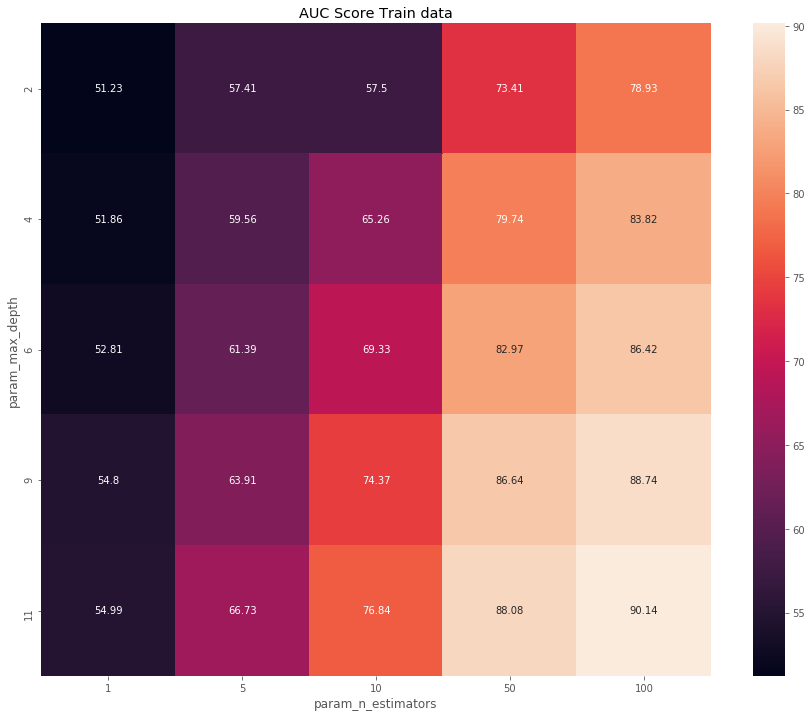

In [110]:
# Train Data Auc Score Vs hyperparameter Heatmap
max_scores = dataframe.groupby(['param_max_depth', 
                                    'param_n_estimators']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
plt.figure(figsize = (15 , 12))
sns.heatmap(max_scores.mean_train_score*100, annot=True, fmt='.4g');
ax = plt.axes()
ax.set_title('AUC Score Train data')
plt.show()

C:\Users\Mahmudur Limon\Anaconda3\envs\gputest\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



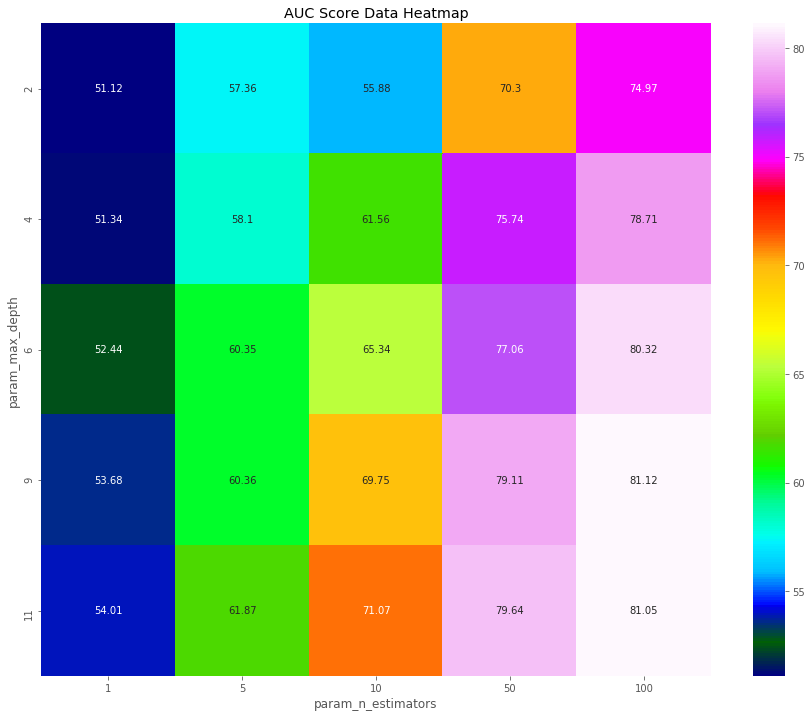

In [111]:
# CV Data Auc Score Vs hyperparameter Heatmap
max_scores = dataframe.groupby(['param_max_depth', 
                                    'param_n_estimators']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
plt.figure(figsize = (15 , 12))
sns.heatmap(max_scores.mean_test_score*100, annot=True, fmt='.4g' , cmap = 'gist_ncar')
ax = plt.axes()
ax.set_title('AUC Score Data Heatmap')
plt.show()

***Test Data Report***
Best max_depth =  11
Best Base Learners =  100
AUC =  74.46272211288895


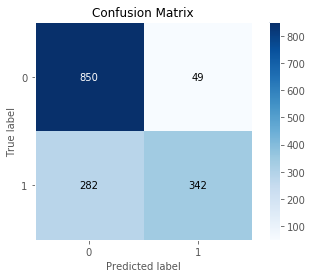

In [112]:
optimal_depth = 11
optimal_estimators = 100

lr = RandomForestClassifier(n_estimators=optimal_estimators, max_depth=optimal_depth, class_weight='balanced')
lr.fit(X_train_BOW,y_train)
pred = lr.predict(X_test_BOW)

print("***Test Data Report***")
print("Best max_depth = ",optimal_depth)
print("Best Base Learners = ",optimal_estimators)
fpr, tpr, threshold = metrics.roc_curve(y_test, lr.predict(X_test))
auc = metrics.auc(fpr, tpr)
print("AUC = ",auc*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)
plt.show()

In [113]:
rf = RandomForestClassifier()
rf.fit(X_train , y_train)

y_pred_rf = rf.predict(X_test)

ac_rf = accuracy_score(y_test , y_pred_rf)
print(ac_rf*100)

79.12015758371635


In [114]:
test_pred = rf.predict(test_BOW)

In [115]:
# test_pred = rf.predict(test_BOW)
# submission['target'] = test_pred.astype(int)
# submission.to_csv('submission02.csv', index=False)

In [116]:
n_folds = 10
parameters = {'max_depth': range(2, 30, 2)}

rf = RandomForestClassifier(random_state = 100)
grd_search_max = GridSearchCV(rf , parameters , cv = n_folds , n_jobs = -1 , return_train_score = True)

grd_search_max.fit(X_train , y_train)
print('Best parameter for max_depth: ',grd_search_max.best_params_)

scores = grd_search_max.cv_results_
pd.DataFrame(scores).head()

Best parameter for max_depth:  {'max_depth': 28}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.797574,0.027108,0.049992,0.009375,2,{'max_depth': 2},0.569787,0.571429,0.566502,0.566502,...,0.565590,0.568509,0.565773,0.565408,0.565408,0.569239,0.567780,0.571793,0.567944,0.002290
1,1.273335,0.040106,0.040081,0.007378,4,{'max_depth': 4},0.599343,0.589491,0.584565,0.584565,...,0.585112,0.585477,0.589491,0.592957,0.593322,0.592593,0.588579,0.588944,0.589911,0.002829
2,1.786014,0.028117,0.035930,0.007158,6,{'max_depth': 6},0.607553,0.599343,0.609195,0.612479,...,0.606824,0.608101,0.606641,0.608466,0.612115,0.607553,0.609013,0.608831,0.607991,0.001724
3,2.449123,0.115701,0.044314,0.012255,8,{'max_depth': 8},0.622332,0.610837,0.619048,0.630542,...,0.621419,0.623244,0.622332,0.623426,0.624156,0.615216,0.621784,0.619595,0.620507,0.003010
4,2.890957,0.048521,0.034367,0.006249,10,{'max_depth': 10},0.642036,0.617406,0.625616,0.642036,...,0.636928,0.635468,0.631454,0.637292,0.632184,0.629995,0.632366,0.636380,0.632822,0.003376


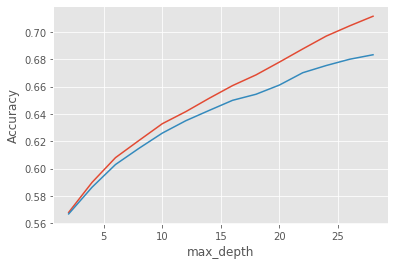

In [117]:
plt.figure()
plt.plot(scores["param_max_depth"],scores["mean_train_score"],label="Training accuracy")
plt.plot(scores["param_max_depth"],scores["mean_test_score"],label="Test accuracy")
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.show()


In [118]:
n_folds = 5
parameters = {'n_estimators': range(50, 500, 50)}

rf = RandomForestClassifier(random_state = 100)
grd_search_est = GridSearchCV(rf , parameters , cv = n_folds , n_jobs = -1 , return_train_score = True)

grd_search_est.fit(X_train, y_train)
print('Best parameter for n_estimators: ',grd_search_est.best_params_)

scores_1 = grd_search_est.cv_results_
pd.DataFrame(scores_1).head()

Best parameter for n_estimators:  {'n_estimators': 350}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,40.744603,1.599712,0.109037,0.001329,50,{'n_estimators': 50},0.779146,0.768473,0.765189,0.775041,...,0.770936,0.005295,9,0.989327,0.990764,0.987890,0.989532,0.989327,0.989368,0.000912
1,74.476703,1.640648,0.215786,0.015567,100,{'n_estimators': 100},0.778325,0.775041,0.774220,0.776683,...,0.774877,0.002767,8,0.990969,0.991995,0.989327,0.990558,0.989737,0.990517,0.000940
2,111.641279,3.181882,0.320220,0.015621,150,{'n_estimators': 150},0.782430,0.772578,0.773399,0.775862,...,0.775205,0.003865,7,0.990969,0.991995,0.989532,0.990558,0.989943,0.990599,0.000855
3,149.269938,4.323939,0.479506,0.082335,200,{'n_estimators': 200},0.781609,0.770936,0.777504,0.775041,...,0.776683,0.003560,4,0.990969,0.991995,0.989532,0.990558,0.989943,0.990599,0.000855
4,187.189494,4.963686,0.540499,0.012496,250,{'n_estimators': 250},0.780788,0.770936,0.779146,0.773399,...,0.776026,0.003612,5,0.990969,0.991995,0.989532,0.990558,0.989943,0.990599,0.000855


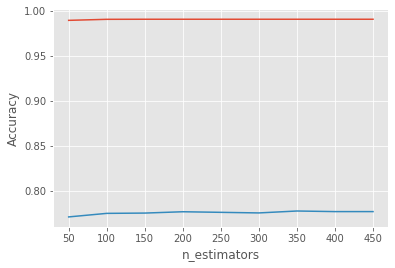

In [119]:
plt.figure()
plt.plot(scores_1["param_n_estimators"],scores_1["mean_train_score"],label="Training accuracy")
plt.plot(scores_1["param_n_estimators"],scores_1["mean_test_score"],label="Test accuracy")
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.show()

In [120]:
n_folds = 5
parameters = {'min_samples_leaf': range(30, 400, 50)}

rf = RandomForestClassifier(random_state = 100)
grd_search_lf = GridSearchCV(rf , parameters , cv = n_folds , return_train_score = True)

grd_search_lf.fit(X_train, y_train)
print('Best parameter for min_samples_leaf: ',grd_search_lf.best_params_)

scores_2 = grd_search_lf.cv_results_
pd.DataFrame(scores_2).head()

Best parameter for min_samples_leaf:  {'min_samples_leaf': 30}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.559119,0.121079,0.043070,0.002544,30,{'min_samples_leaf': 30},0.565681,0.565681,0.565681,0.56486,...,0.565353,0.000402,1,0.565271,0.565271,0.565271,0.565476,0.565476,0.565353,0.000101
1,0.399244,0.017125,0.038081,0.007256,80,{'min_samples_leaf': 80},0.565681,0.565681,0.565681,0.56486,...,0.565353,0.000402,1,0.565271,0.565271,0.565271,0.565476,0.565476,0.565353,0.000101
2,0.419708,0.095831,0.054631,0.018199,130,{'min_samples_leaf': 130},0.565681,0.565681,0.565681,0.56486,...,0.565353,0.000402,1,0.565271,0.565271,0.565271,0.565476,0.565476,0.565353,0.000101
3,0.377370,0.010306,0.041667,0.001731,180,{'min_samples_leaf': 180},0.565681,0.565681,0.565681,0.56486,...,0.565353,0.000402,1,0.565271,0.565271,0.565271,0.565476,0.565476,0.565353,0.000101
4,0.372185,0.020605,0.041484,0.001345,230,{'min_samples_leaf': 230},0.565681,0.565681,0.565681,0.56486,...,0.565353,0.000402,1,0.565271,0.565271,0.565271,0.565476,0.565476,0.565353,0.000101


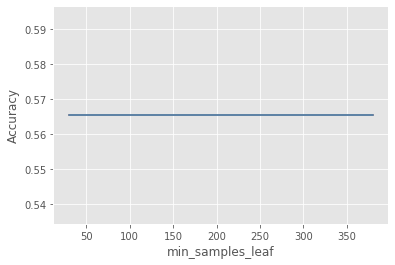

In [121]:
plt.figure()
plt.plot(scores_2["param_min_samples_leaf"],scores_2["mean_train_score"],label="Training accuracy")
plt.plot(scores_2["param_min_samples_leaf"],scores_2["mean_test_score"],label="Test accuracy")
plt.xlabel('min_samples_leaf')
plt.ylabel('Accuracy')
plt.show()

In [122]:
n_folds = 5
parameters = {'min_samples_split': range(10, 400, 50)}

rf = RandomForestClassifier()
grd_search_sp = GridSearchCV(rf , parameters , cv = n_folds , n_jobs = -1, return_train_score = True)

grd_search_sp.fit(X_train, y_train)
print('Best parameter for min_samples_split: ',grd_search_sp.best_params_)

score_3 = grd_search_sp.cv_results_
pd.DataFrame(score_3).head()

Best parameter for min_samples_split:  {'min_samples_split': 310}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,39.490525,0.679775,0.195815,0.006811,10,{'min_samples_split': 10},0.775862,0.773399,0.772578,0.766831,...,0.773071,0.003468,6,0.982759,0.984811,0.981117,0.982143,0.982348,0.982635,0.001215
1,39.393344,4.856762,0.223604,0.033445,60,{'min_samples_split': 60},0.775041,0.766010,0.772578,0.764368,...,0.770115,0.004154,8,0.972085,0.972291,0.971470,0.972701,0.974548,0.972619,0.001043
2,60.962935,14.602571,0.487878,0.166197,110,{'min_samples_split': 110},0.778325,0.772578,0.770115,0.775862,...,0.773071,0.003620,6,0.961412,0.959975,0.963054,0.961412,0.964901,0.962151,0.001686
3,81.214336,6.449776,0.519057,0.154291,160,{'min_samples_split': 160},0.777504,0.767652,0.767652,0.779146,...,0.773892,0.005130,5,0.950328,0.952381,0.953407,0.951765,0.950739,0.951724,0.001112
4,86.105497,10.459417,0.532708,0.146977,210,{'min_samples_split': 210},0.779146,0.767652,0.780788,0.769294,...,0.774384,0.005203,3,0.946223,0.946634,0.948071,0.947455,0.947044,0.947085,0.000641


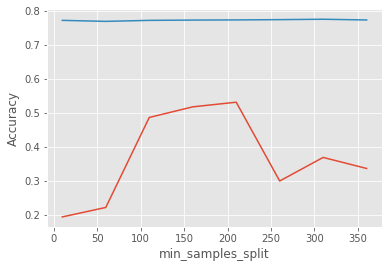

In [123]:
plt.figure()
plt.plot(score_3["param_min_samples_split"],score_3["mean_score_time"],label="Training accuracy")
plt.plot(score_3["param_min_samples_split"],score_3["mean_test_score"],label="Test accuracy")
plt.xlabel('min_samples_split')
plt.ylabel('Accuracy')
plt.show()

In [124]:
print('Best parameter for max_depth: ',grd_search_max.best_params_)
print('Best parameter for min_samples_leaf: ',grd_search_lf.best_params_)
print('Best parameter for min_samples_split: ',grd_search_sp.best_params_)
print('Best parameter for n_estimators: ',grd_search_est.best_params_)

Best parameter for max_depth:  {'max_depth': 28}
Best parameter for min_samples_leaf:  {'min_samples_leaf': 30}
Best parameter for min_samples_split:  {'min_samples_split': 310}
Best parameter for n_estimators:  {'n_estimators': 350}


In [125]:
new_rf = RandomForestClassifier(n_estimators = 350 , max_depth = 28 , min_samples_leaf = 30 , min_samples_split = 160)
new_rf.fit(X_train , y_train)

y_pred_rf = new_rf.predict(X_test)

ac_rf = accuracy_score(y_test , y_pred_rf)
print(ac_rf*100)

59.02823374917925


## GBDT on Bi-grams

In [126]:
learn_rate = {'learning_rate': [0.001 , 0.01 , 0.1 , 1.0 , 1.3]}
folds = 5

In [127]:
GBC = GradientBoostingClassifier()

grd_search_lr = GridSearchCV(GBC , cv = folds , param_grid = learn_rate , n_jobs = -1)
grd_search_lr.fit(X_train, y_train)
print('Best parameter for max_depth: ' , grd_search_lr.best_params_)

cv_results_gbdt = pd.DataFrame(grd_search_lr.cv_results_)
cv_results_gbdt.head()

Best parameter for max_depth:  {'learning_rate': 1.0}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,104.088681,2.420423,0.008193,0.001738,0.001,{'learning_rate': 0.001},0.565681,0.565681,0.565681,0.564860,0.564860,0.565353,0.000402,5
1,99.258522,11.283498,0.005585,0.000489,0.01,{'learning_rate': 0.01},0.677340,0.669130,0.638752,0.654351,0.635468,0.655008,0.016399,4
2,87.210258,1.743543,0.004827,0.002681,0.1,{'learning_rate': 0.1},0.748768,0.725780,0.746305,0.733990,0.743021,0.739573,0.008523,3
3,74.965750,6.390968,0.003810,0.004030,1,{'learning_rate': 1.0},0.766010,0.774220,0.767652,0.752874,0.771757,0.766502,0.007409,1
4,65.875840,2.380933,0.004418,0.004105,1.3,{'learning_rate': 1.3},0.750411,0.761905,0.772578,0.742200,0.761084,0.757635,0.010429,2


In [128]:
sub_sample = {"subsample": [0.3, 0.6, 0.9]}
folds = 5

In [129]:
GBC = GradientBoostingClassifier(max_depth=2, n_estimators=200)

grd_search_ss = GridSearchCV(GBC , cv = folds , param_grid = sub_sample)
grd_search_ss.fit(X_train, y_train)
print('Best parameter for max_depth: ',grd_search_ss.best_params_)

cv_results_sub = pd.DataFrame(grd_search_lr.cv_results_)
cv_results_sub.head()

Best parameter for max_depth:  {'subsample': 0.6}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,104.088681,2.420423,0.008193,0.001738,0.001,{'learning_rate': 0.001},0.565681,0.565681,0.565681,0.564860,0.564860,0.565353,0.000402,5
1,99.258522,11.283498,0.005585,0.000489,0.01,{'learning_rate': 0.01},0.677340,0.669130,0.638752,0.654351,0.635468,0.655008,0.016399,4
2,87.210258,1.743543,0.004827,0.002681,0.1,{'learning_rate': 0.1},0.748768,0.725780,0.746305,0.733990,0.743021,0.739573,0.008523,3
3,74.965750,6.390968,0.003810,0.004030,1,{'learning_rate': 1.0},0.766010,0.774220,0.767652,0.752874,0.771757,0.766502,0.007409,1
4,65.875840,2.380933,0.004418,0.004105,1.3,{'learning_rate': 1.3},0.750411,0.761905,0.772578,0.742200,0.761084,0.757635,0.010429,2


In [130]:
#GBC = GradientBoostingClassifier(subsample = 0.6 , learning_rate = 0.1 , n_estimators=50 , max_features = 8 , min_samples_leaf = 30 , min_samples_split = 10)

GBC = GradientBoostingClassifier(subsample = 0.6 , learning_rate = 1.0 ,  n_estimators=150)
GBC.fit(X_train , y_train)

y_gbr = GBC.predict(X_test)

ac_gbr = accuracy_score(y_test , y_gbr)
print(ac_gbr*100)

76.42810242941562


## XGB on Bi-grams

In [131]:
classifier = XGBClassifier()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

ac_xg = accuracy_score(y_test , y_pred)
print(ac_xg*100)

79.9080761654629


In [132]:
max_depths = [2,4,6,9,11]
base_learners = [1, 5, 10, 50, 100]
param_grid = {'max_depth': max_depths,'n_estimators':base_learners}

model = GridSearchCV(xgb.XGBClassifier(scale_pos_weight=1), param_grid, scoring = 'roc_auc', cv=3 , n_jobs = -1 , return_train_score = True) 
model.fit(X_train, y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_train, y_train))

Model with best parameters :
 XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=11,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
Accuracy of the model :  0.9612912364909624


***Test Data Report***
Best max_depth =  11
Best Base Learners =  100
AUC =  74.46272211288895


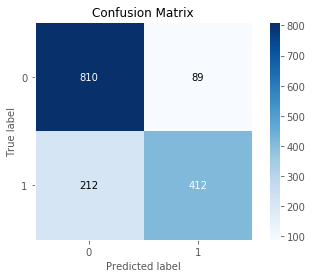

In [133]:
xg_model = xgb.XGBClassifier(max_depth=optimal_depth, n_estimators=optimal_estimators, scale_pos_weight=1)
xg_model.fit(X_train,y_train)

pred = xg_model.predict(X_test)

print("***Test Data Report***")
print("Best max_depth = ",optimal_depth)
print("Best Base Learners = ",optimal_estimators)
fpr, tpr, threshold = metrics.roc_curve(y_test, lr.predict(X_test))
auc = metrics.auc(fpr, tpr)
print("AUC = ",auc*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)
plt.show()

In [136]:
# test_pred = classifier.predict(test_BOW)

# submission['target'] = test_pred.astype(int)
# submission.to_csv('submission04xgb.csv', index=False)